# Family-friendly Neighbourhoods in Melbourne, AU

## Table of contents
* [Introduction](#introduction)
* [Data Description](#description)
* [Data Preparation](#preparation)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

The local government of Melbourne in Australia wants to compile information about the venues and facilities suitable for families with children under 15 years old. The final objective is to improve local communities' public areas for families with children. Thus the goal of this study is to find which suburbs need more resources for this purpose.

The analysis will use data from the Australian Bureau of Statistics (<a href="https://www.abs.gov.au/">ABS</a>) to compile data about families per suburb and the API of <a href="https://foursquare.com/">Foursquare</a> to gather the venues of each locality.

## Data Description <a name="description"></a>

The first dataset downloaded from ABS has aggregations of family composition and other statistics grouped by the suburbs of the State of Victoria in Australia. It comes with several columns, but we will use the three we need to extract information about families. These columns gives us the number of couple families with children under 15 years `CF_ChU15_a_Total_F`, one-parent families with children under 15 years `OPF_ChU15_a_Total_F` and the total of families `Total_F`.

Each row of this dataset is the aggregation data per suburb with an ID of 5 digits named SSC (State Suburb Code) and assigned by the ABS.

An example of the data looks like this:

| SSC_CODE_2016 | ...  | CF_ChU15_a_Total_F | ...  | OPF_ChU15_a_Total_F | ... | Total_F | ...  |
|---------------|------|--------------------|------|---------------------|-----|---------|------|
| ...           | ...  | ...                | ...  | ...                 | ... | ...     | ...  |
| SSC20002      | ...  | 353                | ...  | 58                  | ... | 1886    | ...  |
| SSC20003      | ...  | 356                | ...  | 39                  | ... | 1034    | ...  |
| ...           | ...  | ...                | ...  | ...                 | ... | ...     | ...  |

We can get a ratio of families with children per suburb with the equation:

> (`CF_ChU15_a_Total_F` + `OPF_ChU15_a_Total_F`) / `Total_F`

The Victorian government also provided a dataset `CG_SSC_2016_SA4_2016.csv` with the correspondence between SSC and SA4, which are large statistic areas defined by ABS. Those that have 'Melbourne' as part of its name `SA4_NAME_2016` represent the areas of the city with their corresponding suburbs. With this dataset, we can filter out from the previous one any suburb out of the Melbourne area. This dataset looks like this:

| SSC_CODE_2016 | SSC_NAME_2016       | SA4_CODE_2016 | SA4_NAME_2016          | RATIO | PERCENTAGE |
|---------------|---------------------|---------------|------------------------|-------|------------|
| 20172         | Bayswater (Vic.)    | 211           | Melbourne - Outer East | 1     | 100        |
| 20173         | Bayswater North     | 211           | Melbourne - Outer East | 1     | 100        |
| 20174         | Beaconsfield (Vic.) | 212           | Melbourne - South East | 1     | 100        |
| 20175         | Beaconsfield Upper  | 212           | Melbourne - South East | 1     | 100        |
| 20176         | Bealiba             | 201           | Ballarat               | 1     | 100        |
| 20177         | Bearii              | 216           | Shepparton             | 1     | 100        |
| 20178         | Bears Lagoon        | 202           | Bendigo                | 1     | 100        |

Now we will be able to go through each suburb and find the venues that are suitable for families with children. To only get those venues we are interested in, we will pass 50 categories chosen from the full list of Foursquare categories <a href="https://developer.foursquare.com/docs/resources/categories">here</a>.

At this point, we will know how many venues per category every suburb of Melbourne has. Adding this information to the ratio of families, we can run k-means clustarting with 5 clusters until we find the optimun value for k using the elbow method. When we have the best k parameter, we can finally get that many clusters of suburbs for the government to analyse and support depending on the outcome.

#### Final recommendations on how to interpret the final result

- Suburbs with a low ratio of families with children should be of low priority.
- Suburbs with a high ratio of families with children and a high number of suitable venues should be of low priority to create new facilities. The focus here should be on maintenance of the current infrastructure and businesses.
- Suburbs with a high ratio of families with children and a low number of suitable venues should be the focus of the government plan and give top priority to these areas.

## Data Preparation <a name="preparation"></a>

The first step is to download the demographics data from ABS with the aggregations of families with children in the State of Victoria. With this dataset, we want to obtain only the data for Melbourne and transform the numbers to use only the ratio of families per suburb.

In [68]:
import pandas as pd

df_families = pd.read_csv('https://raw.githubusercontent.com/tiomno/Coursera_Capstone/master/datasets/2016Census_G25_VIC_SSC.csv')
df_families.head()

,SSC_CODE_2016,CF_no_children_F,CF_no_children_P,CF_ChU15_a_DSs_a_NdCh_F,CF_ChU15_a_DSs_a_NdCh_P,CF_ChU15_a_DSs_a_no_NdCh_F,CF_ChU15_a_DSs_a_no_NdCh_P,CF_ChU15_a_no_DSs_a_NdCh_F,CF_ChU15_a_no_DSs_a_NdCh_P,CF_ChU15_a_no_DSs_a_no_NdCh_F,...,OPF_no_ChU15_no_DSs_a_NdCh_F,OPF_no_ChU15_no_DSs_a_NdCh_P,OPF_no_ChU15_a_Total_F,OPF_no_ChU15_a_Total_P,OPF_Total_F,OPF_Total_P,Other_family_F,Other_family_P,Total_F,Total_P
0,SSC20001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,SSC20002,1164,2281,0,7,25,111,4,10,327,...,66,134,104,208,154,342,81,171,1886,4539
2,SSC20003,287,561,13,66,84,390,9,32,256,...,57,131,91,213,129,328,13,32,1034,3282
3,SSC20004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SSC20005,21,44,0,0,0,8,0,0,9,...,0,3,0,3,3,11,0,0,40,109


In [69]:
# Get rid of the prefix 'SSC' for SSC_CODE_2016
df_families['SSC_CODE_2016'] = df_families['SSC_CODE_2016'].str[-5:].astype(int)

# Calculate the ratios of families with children per suburb. Remove any area with no population declared.
df_families.drop(df_families[df_families['Total_F'] == 0].index, inplace=True)
df_families['ratio'] = (
    df_families['CF_ChU15_a_Total_F'] + df_families['OPF_ChU15_a_Total_F']
) / df_families['Total_F']

# Remove unnecessary columns and rename SSC_CODE_2016 to ssc
df_families = df_families[['SSC_CODE_2016', 'ratio']]
df_families.columns = ['ssc', 'ratio']
df_families.head()

,ssc,ratio
1,20002,0.217922
2,20003,0.382012
4,20005,0.300000
6,20007,0.187500
7,20008,0.200000


In [70]:
# Obtain the correspondence between ABS larger areas SA4 and pick only the suburbs in and around the CBD of Melbourne

df_correspondence = pd.read_csv('https://raw.githubusercontent.com/tiomno/Coursera_Capstone/master/datasets/CG_SSC_2016_SA4_2016.csv')
df_correspondence.head()

,SSC_CODE_2016,SSC_NAME_2016,SA4_CODE_2016,SA4_NAME_2016,RATIO,PERCENTAGE
0,10001,Aarons Pass,103,Central West,1.0,100.0
1,10002,Abbotsbury,127,Sydney - South West,1.0,100.0
2,10003,Abbotsford (NSW),120,Sydney - Inner West,1.0,100.0
3,10004,Abercrombie,103,Central West,1.0,100.0
4,10005,Abercrombie River,103,Central West,1.0,100.0


In [71]:
# Get only the list of suburbs from Melbourne
df_melbourne = df_correspondence[df_correspondence['SA4_NAME_2016'].str.contains('Melbourne - Inner')][['SSC_CODE_2016', 'SSC_NAME_2016']]
df_melbourne.columns = ['ssc', 'name']
df_melbourne.head()

,ssc,name
4595,20002,Abbotsford (Vic.)
4596,20003,Aberfeldie
4610,20017,Albert Park (Vic.)
4626,20033,Alphington
4660,20065,Armadale (Vic.)


In [72]:
# Get rid of any suburb from the df_families other than Melbourne's
print('Families dataframe shape: {}'.format(df_families.shape))
print('Melbourne dataframe shape: {}'.format(df_melbourne.shape))
df_melbourne_families = pd.merge(df_families, df_melbourne, on=['ssc'])
print('Melbourne Families dataframe shape: {}'.format(df_melbourne_families.shape))
df_melbourne_families.head()

Families dataframe shape: (2717, 2)
Melbourne dataframe shape: (126, 2)
Melbourne Families dataframe shape: (125, 3)


,ssc,ratio,name
0,20002,0.217922,Abbotsford (Vic.)
1,20003,0.382012,Aberfeldie
2,20017,0.362508,Albert Park (Vic.)
3,20033,0.363782,Alphington
4,20065,0.325092,Armadale (Vic.)


Then we can load the categories we will pass to Foursquare to search for venues suitable for families with children.

In [73]:
# Load the Foursquare categories in pandas
df_categories = pd.read_csv('https://raw.githubusercontent.com/tiomno/Coursera_Capstone/master/datasets/Foursquare_categories.csv')
df_categories.head()

,Category Name,Category ID
0,Aquarium,4fceea171983d5d06c3e9823
1,Art Gallery,4bf58dd8d48988d1e2931735
2,Exhibit,56aa371be4b08b9a8d573532
3,General Entertainment,4bf58dd8d48988d1f1931735
4,Historic Site,4deefb944765f83613cdba6e


In [74]:
# And create a comma separated string with the category IDs to pass in the Query String of the Foursquare URL request.
CATEGORIES = ','.join(df_categories['Category ID'].values.tolist())
CATEGORIES

'4fceea171983d5d06c3e9823,4bf58dd8d48988d1e2931735,56aa371be4b08b9a8d573532,4bf58dd8d48988d1f1931735,4deefb944765f83613cdba6e,5642206c498e4bfca532186c,4bf58dd8d48988d17f941735,4bf58dd8d48988d181941735,4bf58dd8d48988d1e3931735,507c8c4091d498d9fc8c67a9,4bf58dd8d48988d184941735,4bf58dd8d48988d182941735,4bf58dd8d48988d193941735,4bf58dd8d48988d17b941735,5267e4d9e4b0ec79466e48c7,52741d85e4b0d5d1e3c6a6d9,5bae9231bedf3950379f89c5,5267e4d8e4b0ec79466e48c5,5bae9231bedf3950379f89c3,4bf58dd8d48988d128941735,4bf58dd8d48988d16d941735,4bf58dd8d48988d1e0931735,4bf58dd8d48988d120951735,4bf58dd8d48988d1ca941735,52e81612bcbc57f1066b7a2c,4cce455aebf7b749d5e191f5,52e81612bcbc57f1066b7a2e,52e81612bcbc57f1066b7a28,56aa371be4b08b9a8d573544,4bf58dd8d48988d1e2941735,56aa371be4b08b9a8d57355e,52e81612bcbc57f1066b7a22,4bf58dd8d48988d1df941735,4bf58dd8d48988d1e5941735,52e81612bcbc57f1066b7a23,56aa371be4b08b9a8d573547,4bf58dd8d48988d15a941735,5744ccdfe4b0c0459246b4b5,4bf58dd8d48988d161941735,52e81612bcbc57f1066b7a21

Now we need to get the geolocation for each suburb. For this, we can use geopy.

In [75]:
#!conda install -c conda-forge geopy --yes # uncomment this if geopy needs to be install in the environment
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

The following code is commented out not to gather the geolocation again as it may take a few minutes. At the end, the results were saved in a CSV file for further processing.

In [8]:
# geolocator = Nominatim(user_agent="ny_explorer")

# # Define a function that gets the geolocation of a suburb.
# def get_suburb_geolocation(suburb, geolocation):
#     try:
#         if geolocation[0] is None:
#             location = geolocator.geocode(suburb + ',VIC,Australia')
#             if location is None:
#                 print('x ', end='')
#                 return None, None
#             else:
#                 print('o ', end='')
#                 return location.latitude, location.longitude
#         else:
#             return geolocation
#     except:
#         return None, None

# # Go through the dataframe of suburbs and add the geolocation
# # Repeat the preocess until all the suburb are filled in
# # Then, save it to a CSV file for further use.
# df_melbourne_families["geolocation"] = [(None, None)] * len(df_melbourne_families)
# i = 0
# while len(df_melbourne_families[df_melbourne_families['geolocation'] == (None, None)]) > 0 and i < 20:
#     df_melbourne_families['geolocation'] = df_melbourne_families.apply(
#         lambda df: get_suburb_geolocation(df['name'], df['geolocation']), axis=1
#     )
#     i += 1

# df_melbourne_families.to_csv('df_melbourne_families.csv')

In [83]:
df_melbourne_families = pd.read_csv('https://raw.githubusercontent.com/tiomno/Coursera_Capstone/master/datasets/df_melbourne_families.csv')
# Remove SSC duplication due to the correspondence with SA4 areas
bool_series = df_melbourne_families["ssc"].duplicated() 
df_melbourne_families = df_melbourne_families[~bool_series] 
df_melbourne_families.head() 

,ssc,ratio,name,geolocation
0,20002,0.217922,Abbotsford (Vic.),"(-37.8045508, 144.9988542)"
1,20003,0.382012,Aberfeldie,"(-37.7596196, 144.8974571)"
2,20017,0.362508,Albert Park (Vic.),"(-37.8477725, 144.96200797154074)"
3,20033,0.363782,Alphington,"(-37.7783953, 145.0312823)"
4,20065,0.325092,Armadale (Vic.),"(-37.8567619, 145.0206905)"


With the suburbs geolocation we can request Foursquare to gather the venues suitable for families with children.

In [84]:
# Foursquare parameters
CLIENT_ID = 'Foursquare API Client ID here'
CLIENT_SECRET = 'Foursquare API Secret here'
VERSION = '20180604'
LIMIT = 30
RADIUS = 500

url_template = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, '{}', VERSION, CATEGORIES, RADIUS, LIMIT)
url_template

'https://api.foursquare.com/v2/venues/search?client_id=Foursquare API Client ID here&client_secret=Foursquare API Secret here&ll={}&v=20180604&categoryId=4fceea171983d5d06c3e9823,4bf58dd8d48988d1e2931735,56aa371be4b08b9a8d573532,4bf58dd8d48988d1f1931735,4deefb944765f83613cdba6e,5642206c498e4bfca532186c,4bf58dd8d48988d17f941735,4bf58dd8d48988d181941735,4bf58dd8d48988d1e3931735,507c8c4091d498d9fc8c67a9,4bf58dd8d48988d184941735,4bf58dd8d48988d182941735,4bf58dd8d48988d193941735,4bf58dd8d48988d17b941735,5267e4d9e4b0ec79466e48c7,52741d85e4b0d5d1e3c6a6d9,5bae9231bedf3950379f89c5,5267e4d8e4b0ec79466e48c5,5bae9231bedf3950379f89c3,4bf58dd8d48988d128941735,4bf58dd8d48988d16d941735,4bf58dd8d48988d1e0931735,4bf58dd8d48988d120951735,4bf58dd8d48988d1ca941735,52e81612bcbc57f1066b7a2c,4cce455aebf7b749d5e191f5,52e81612bcbc57f1066b7a2e,52e81612bcbc57f1066b7a28,56aa371be4b08b9a8d573544,4bf58dd8d48988d1e2941735,56aa371be4b08b9a8d57355e,52e81612bcbc57f1066b7a22,4bf58dd8d48988d1df941735,4bf58dd8d48988d1e5941

Let's add the venue categories as columns to the Melbourne families dataframe. Then, fill in the number of venues per category in the neighbourhood.

The following code is commented out not to request Foursquare as it's a bit time consuming. At the end, the results were saved in a CSV file for further processing.

In [11]:
# import requests # library to handle requests

# # Add new categories as clumns to df_melbourne_families
# for category in df_categories['Category Name']:
#     df_melbourne_families[category] = 0

# def get_category_venues(ssc, geolocation):
#     lst_venues=[]

#     for ssc, location in zip(ssc, geolocation):
#         lat_lng = location.strip('()')
            
#         # create the API request URL
#         url = url_template.format(lat_lng)
            
#         # make the GET request
#         venues = requests.get(url).json()["response"]['venues']
        
#         # Append ssc and category to the venues list to group them in further steps
#         lst_venues.append([
#             (ssc, venue['categories'][0]['name']) for venue in venues
#         ])

#     return pd.DataFrame([item for lst in lst_venues for item in lst], columns=['ssc', 'category'])

    
# df_categories_ssc = get_category_venues(
#     ssc=df_melbourne_families['ssc'],
#     geolocation=df_melbourne_families['geolocation']
# )
# df_categories_ssc.to_csv('categories_ssc.csv', index=False)

In [85]:
df_categories_ssc = pd.read_csv('https://raw.githubusercontent.com/tiomno/Coursera_Capstone/master/datasets/categories_ssc.csv')
df_categories_ssc.head()

,ssc,category
0,20002,Park
1,20002,Park
2,20002,Cultural Center
3,20002,Coffee Shop
4,20002,Café


In [86]:
# Group categories by SSC (suburb) and get the ratio from the total.

# Add dummy value to count 1 per each row and venue
df_categories_ssc['venues'] = 1

# Count venues per category and total by SSC
df_categories_ssc['venues_count'] = df_categories_ssc.groupby(['ssc', 'category'])['venues'].transform('sum')

# Remove extra columns and row duplications
df_categories_ssc = df_categories_ssc[['ssc', 'category', 'venues_count']].drop_duplicates()
# Convert categories into columns with venues counts as cell values
df_categories_ssc = df_categories_ssc.pivot_table(
    values='venues_count', index=df_categories_ssc.ssc, columns='category', aggfunc='first', fill_value=0
)
df_categories_ssc.reset_index(level=0, inplace=True)
df_categories_ssc.head()

category,ssc,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
0,20002,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20017,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20033,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20065,0,3,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


We'll merge the list of suburbs with the counts of venues per categories and start playing with clustering algorithm.

In [87]:
df_melbourne_venues = pd.merge(df_melbourne_families, df_categories_ssc, on=['ssc'])
df_melbourne_venues.head()

,ssc,ratio,name,geolocation,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
0,20002,0.217922,Abbotsford (Vic.),"(-37.8045508, 144.9988542)",0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20003,0.382012,Aberfeldie,"(-37.7596196, 144.8974571)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20017,0.362508,Albert Park (Vic.),"(-37.8477725, 144.96200797154074)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20033,0.363782,Alphington,"(-37.7783953, 145.0312823)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20065,0.325092,Armadale (Vic.),"(-37.8567619, 145.0206905)",0,3,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Methodology <a name="methodology"></a>

With the necessary data at hand, we can use a clustering algorithm to identify a pattern in the dataset that shows us the relation between the family ratio and the venues suitable for families in a suburb.

We can use K-means ML algorithm for this purpose and play with different numbers of clusters until we get a value suitable for the work of the local government. A small number of clusters would give us too many different suburbs in a single group which is not of much help. On the other hand, too many groups would make difficult the task of identifying patterns and allocate the necessary resources and team of experts to each group.

Clustering is the perfect solution to identify segments of suburbs in the city. Still, we needed to focus the attention on specific variables. To identify those variables, we had discussions with the local government to know which group of the population we needed to target. Then, based on the final goal, define the kind of venues suitable for families in this study.

Knowing the segment of the population to target and the categories of the venues we needed to find, we started the search for the right tools and information available. Gathering aggregations from the Australian Bureau of Statistics website, we obtained insight into the shape of the families' distribution in Melbourne. With the Foursquare API, we could search for the venues suitable for families in each suburb.

We merged this information and are ready to run the clustering algorithm and analyse the results.

## Analysis <a name="analysis"></a>

Let's try to find the optimun number of cluster from a range from 5 - 20 using the Elbow method.

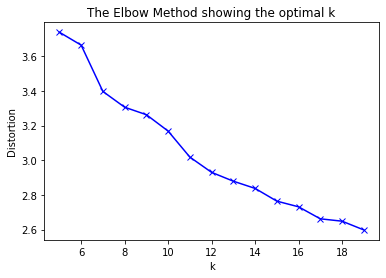

In [88]:
# source: https://pythonprogramminglanguage.com/kmeans-elbow-method/

from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# create new plot and data
plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(5, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_melbourne_venues_clustering)
    kmeanModel.fit(df_melbourne_venues_clustering)
    distortions.append(sum(np.min(
        cdist(df_melbourne_venues_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1
    )) / df_melbourne_venues_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can pick 17 clusters and continue with the anlysis of Melbourne suburbs.
> note: see Results and Discussion section at the bottom of this notebook for thoughts about this method.

In [89]:
# set number of clusters
kclusters = 17

df_melbourne_venues_clustering = df_melbourne_venues.drop(columns=['ssc', 'name', 'geolocation'])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_melbourne_venues_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([ 8,  3, 10,  0, 12, 11, 11,  0,  3, 15], dtype=int32)

In [90]:
# add clustering labels to the Melbourne venues dataframe
df_melbourne_venues.insert(0, 'Cluster Labels', kmeans.labels_)
df_melbourne_venues.head()

,Cluster Labels,ssc,ratio,name,geolocation,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
0,8,20002,0.217922,Abbotsford (Vic.),"(-37.8045508, 144.9988542)",0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,20003,0.382012,Aberfeldie,"(-37.7596196, 144.8974571)",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,20017,0.362508,Albert Park (Vic.),"(-37.8477725, 144.96200797154074)",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,20033,0.363782,Alphington,"(-37.7783953, 145.0312823)",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,20065,0.325092,Armadale (Vic.),"(-37.8567619, 145.0206905)",0,3,1,0,0,...,0,0,1,0,0,0,0,0,0,0


Showing the clusters on a map will give us an idea of the distribution by kind of venues.

In [91]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this if folium needs to be install in the environment
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [94]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode('Melbourne, Australia')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Melbourne are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for location, name, cluster in zip(
    df_melbourne_venues['geolocation'], df_melbourne_venues['name'], df_melbourne_venues['Cluster Labels']
):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    [lat, lng] = map(float, location.strip('()').split(', '))
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinates of Melbourne are -37.8142176, 144.9631608.


Let's take a closer look at the data of each cluster.

The following piece of code will iterate the clusters and show:

- How many suburbs the cluster has been shown in the first row.
- The mean value for the families ratio and the occurrence of each type of venue.


In [95]:
for i in range(kclusters):
    print('Cluster {}:'.format(i))
    display(
        df_melbourne_venues.loc[
            df_melbourne_venues['Cluster Labels'] == i,
            df_melbourne_venues.columns[[2] + list(range(5, df_melbourne_venues.shape[1]))]
        ].describe().head(2)
    )

Cluster 0:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,24.000000,24.0,24.000,24.0,24.0,24.0,24.000000,24.000000,24.000000,24.000000,...,24.0,24.0,24.0,24.000000,24.0,24.000000,24.000000,24.0,24.0,24.0
mean,0.358725,0.0,0.125,0.0,0.0,0.0,0.041667,0.041667,0.041667,0.041667,...,0.0,0.0,0.0,0.083333,0.0,0.041667,0.041667,0.0,0.0,0.0


Cluster 1:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,5.000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
mean,0.385723,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0


Cluster 2:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,11.00000,11.000000,11.000000,11.0,11.0,11.0,11.0,11.000000,11.000000,11.0,...,11.000000,11.0,11.000000,11.000000,11.0,11.000000,11.0,11.0,11.0,11.0
mean,0.33668,0.090909,0.636364,0.0,0.0,0.0,0.0,0.090909,0.181818,0.0,...,0.090909,0.0,0.272727,0.272727,0.0,0.090909,0.0,0.0,0.0,0.0


Cluster 3:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,24.000000,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.000000,24.0,...,24.0,24.0,24.0,24.000000,24.0,24.0,24.0,24.0,24.0,24.0
mean,0.370998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,...,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0


Cluster 4:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,6.000000,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.000000,...,6.0,6.0,6.0,6.000000,6.0,6.0,6.0,6.0,6.0,6.0
mean,0.307153,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.333333,...,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0


Cluster 5:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.154968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cluster 6:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.255165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.0


Cluster 7:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.369052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cluster 8:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,5.000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
mean,0.271158,0.0,1.8,0.0,0.0,0.2,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cluster 9:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,6.000000,6.000000,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.000000,6.0,6.000000,6.0,6.0
mean,0.343331,0.166667,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.166667,0.0,0.0


Cluster 10:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,9.000000,9.0,9.000000,9.0,9.0,9.0,9.0,9.0,9.000000,9.0,...,9.0,9.0,9.0,9.000000,9.000000,9.0,9.0,9.0,9.0,9.0
mean,0.356341,0.0,0.444444,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,...,0.0,0.0,0.0,0.111111,0.111111,0.0,0.0,0.0,0.0,0.0


Cluster 11:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,7.000000,7.0,7.000000,7.0,7.0,7.0,7.0,7.0,7.000000,7.000000,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
mean,0.392382,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.142857,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cluster 12:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,7.000000,7.0,7.000000,7.000000,7.0,7.0,7.0,7.0,7.000000,7.000000,...,7.0,7.0,7.000000,7.0,7.0,7.0,7.0,7.0,7.0,7.0
mean,0.289062,0.0,3.285714,0.142857,0.0,0.0,0.0,0.0,0.428571,0.285714,...,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cluster 13:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,5.000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
mean,0.233466,0.0,0.6,0.0,0.0,0.0,0.0,0.2,0.2,0.2,...,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.2


Cluster 14:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.365085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Cluster 15:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,4.000000,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.00,...,4.0,4.00,4.00,4.0,4.0,4.00,4.0,4.0,4.0,4.0
mean,0.330014,0.0,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.25,...,0.0,0.25,0.25,0.0,0.0,0.25,0.0,0.0,0.0,0.5


Cluster 16:


,ratio,American Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,...,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Zoo,Zoo Exhibit
count,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.294693,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Results and Discussion <a name="results"></a>

Clusters with suburbs showing a mean of 0.3 or more tell us that 30% or more of the families there have children; these are prospective candidates to work with. If the suburbs don't have enough venues or an irregular distribution among the types of venues, they are definitely candidates for the work of the local government.

It's important to note one limitation of the analysis in this notebook:
> We only get venues in a radius of 500 meters from the centre of the suburb and limit the search to only 30 venues. A substantial improvement would be not to limit the number of venues we can gather. Also, to request the venues in a radius big enough to go out of each suburb, then filter out those venues not located in the suburb by matching the address.

> The elbow method to select the number of clusters is not the most appropriate way to select groups of clusters in this study. There is not an evident change in the curve of the graph, which indicates an optimal number. This may be due to the high diversity of data among the suburbs in Melbourne. A more realistic approach would be for the local government to define how many groups they want to work with. Depending on budget, resources and time to tackle the field studies and projects. It can be 17, as shown here or a different number.

One approach is to select three different number of clusters suitable for the work and build three reports for the local government to choose the most feasible for the task.

## Conclusion <a name="conclusion"></a>

The study presented here is a good start point for the local government of Melbourne to solve the problem of suitable venues for families with children. With a full licence of Foursquare to request data about venues, plus gathering information from government archives and other online services like Google Places, the dataset of venues would be much more valuable for a better outcome.

It is critical to have discussions with stakeholders and contractors in charge of the project and logistics to define what number of clusters is the most appropriate.

After having a plan base on this study, further discussion with local councils can be of great feedback to make it more accurate and find the best possible distribution of the local resources in the area.

### Thank you for reviewing this work!

This notebook was created by [Israel Tiomno](https://www.linkedin.com/in/tiomno/) following the fantastic work of [Alex Aklson](https://www.linkedin.com/in/aklson/) and [Polong Lin](https://www.linkedin.com/in/polonglin/) in the notebook "Segmenting and Clustering Neighborhoods in New York City" as a guide.

<hr>

Copyright &copy; 2020 [Israel Tiomno](https://github.com/tiomno). This notebook and its source code are released under the terms of the MIT License.